<a href="https://colab.research.google.com/github/aidaaminian/snn-self-driving/blob/main/bproj_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Install and Import

In [ ]:
!gdown --id 1BuZNKbH3qWgedopUGwW9Gfue7oCbBTDm

In [ ]:
!unzip "/content/traffic-sign-yolo.zip" -d "/content/"

In [ ]:
!pip install nengo
!pip install nengo-dl

In [ ]:
%matplotlib inline
import nengo
import nengo_dl
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from urllib.request import urlretrieve
import skimage
from sklearn.model_selection import train_test_split

### Load Data

In [ ]:
IMG_HEIGHT = 240
IMG_WIDTH = 240
MINIBATCH_SIZE = 32
N_STEPS = 20

In [ ]:
dir_path = '/content/'

In [ ]:
import cv2
import glob
image_list = []
for filename in glob.glob(dir_path + 'traffic-sign-yolo/*.jpg'):
    image = cv2.imread (filename)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    image = cv2.resize(image,(240,240))
    image_list.append (image)

### Data Preprocessing

In [ ]:
np.array(image_list).shape

In [ ]:
image_list = np.array(image_list, dtype=np.float32) /255

In [ ]:
noise_data = skimage.util.random_noise(image_list, mode="gaussian")

In [ ]:
noise_data = np.array(noise_data*255, dtype=np.uint8)

In [ ]:
image_list = np.array(image_list*255, dtype=np.uint8)

In [ ]:
noise_data

In [ ]:
image_list

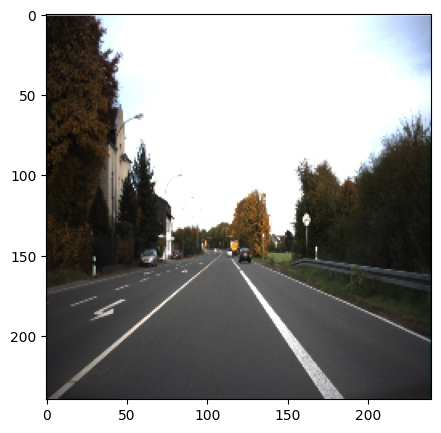

In [ ]:
plt.figure(figsize=(5,5))
plt.imshow(image_list[8])
plt.show()

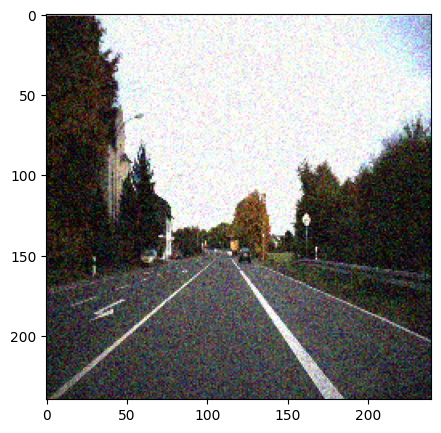

In [ ]:
plt.figure(figsize=(5,5))
plt.imshow(noise_data[8])
plt.show()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(noise_data, image_list, test_size=0.1, random_state=43)

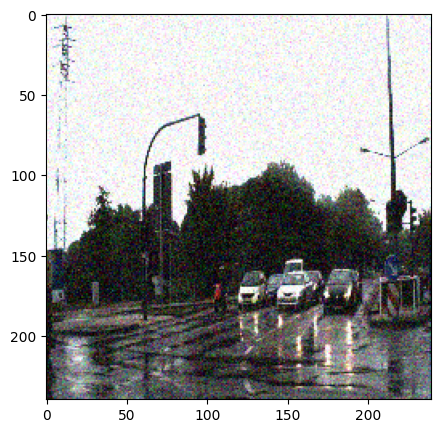

In [ ]:
plt.figure(figsize=(5,5))
plt.imshow(X_train[8])
plt.show()

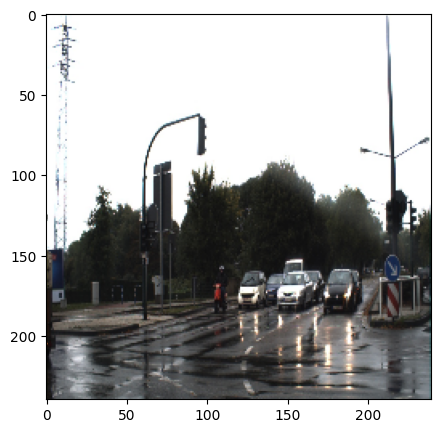

In [ ]:
plt.figure(figsize=(5,5))
plt.imshow(y_train[8])
plt.show()

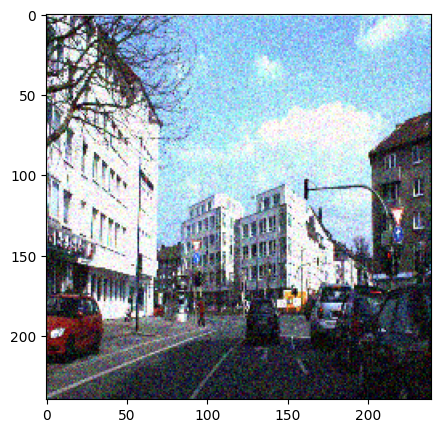

In [ ]:
plt.figure(figsize=(5,5))
plt.imshow(X_test[8])
plt.show()

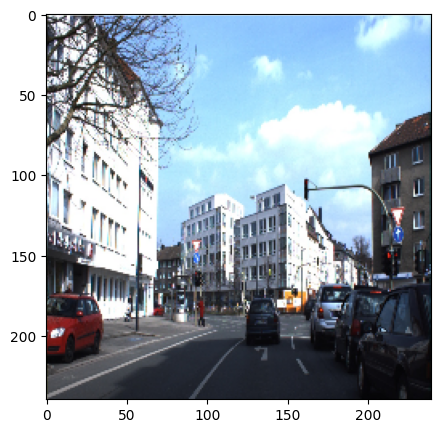

In [ ]:
plt.figure(figsize=(5,5))
plt.imshow(y_test[8])
plt.show()

In [ ]:
del noise_data
del image_list

In [ ]:
X_train = np.reshape(X_train, (len(X_train), -1))
X_test = np.reshape(X_test, (len(X_test), -1))
y_train = np.reshape(y_train, (len(y_train), -1))
y_test = np.reshape(y_test, (len(y_test), -1))

In [ ]:
X_train.shape

In [ ]:
X_test.shape

In [ ]:
y_train.shape

In [ ]:
y_test.shape

### Autoencoder Network

In [ ]:
with nengo.Network(seed = 0) as auto_net:
    auto_net.config[nengo.Ensemble].max_rates = nengo.dists.Choice([200])
    auto_net.config[nengo.Ensemble].intercepts = nengo.dists.Choice([0])
    auto_net.config[nengo.Connection].synapse = None

    n_type = nengo.SpikingRectifiedLinear()
    n_in = IMG_HEIGHT*IMG_WIDTH*3
    dim_hidden = 512
    dim_center = 128

    input_node = nengo.Node(np.zeros(n_in))

    layer1 = nengo.Ensemble(dim_hidden, 1, neuron_type = n_type)
    nengo.Connection(input_node, layer1.neurons, transform=nengo_dl.dists.Glorot())

    layer2 = nengo.Ensemble(dim_center, 1, neuron_type = n_type)
    nengo.Connection(layer1.neurons, layer2.neurons, transform=nengo_dl.dists.Glorot())

    layer3 = nengo.Ensemble(dim_hidden, 1, neuron_type = n_type)
    nengo.Connection(layer2.neurons, layer3.neurons, transform=nengo_dl.dists.Glorot())

    outp = nengo.Ensemble(n_in, 1, neuron_type=n_type)
    nengo.Connection(layer3.neurons, outp.neurons, transform=nengo_dl.dists.Glorot())

    p_c = nengo.Probe(outp.neurons)
    p_c_filt = nengo.Probe(outp.neurons, synapse=0.01, label="out_p_filt")

In [ ]:
with nengo_dl.Simulator(network=auto_net, minibatch_size=MINIBATCH_SIZE) as sim:
  sim.predict(np.ones((MINIBATCH_SIZE, 1, n_in)));

Build finished in 0:00:04                                                      
Optimization finished in 0:00:00                                               
Construction finished in 0:00:03                                               


/usr/local/lib/python3.10/dist-packages/nengo_dl/simulator.py:1003: UserWarning: Running for one timestep, but the network contains synaptic filters (which will introduce at least a one-timestep delay); did you mean to set synapse=None?
  warnings.warn(


1/1 [==============================] - 3s 3s/step


### Train Model

In [ ]:
for net_ens in auto_net.all_ensembles:
  net_ens.gain = nengo.dists.Choice([1])
  net_ens.bias = nengo.dists.Choice([0])

In [ ]:
for conn in auto_net.all_connections:
  conn.synapse = None

In [ ]:
X_train = X_train[:, None, :]

In [ ]:
y_train = y_train[:, None, :]

In [ ]:
X_train.shape

In [ ]:
y_train.shape

In [ ]:
X_test = np.tile(X_test[:, None, :], (1, N_STEPS, 1))

In [ ]:
X_test.shape

In [ ]:
X_train

In [ ]:
y_train

In [ ]:
X_test

In [ ]:
with nengo_dl.Simulator(auto_net, minibatch_size=MINIBATCH_SIZE) as sim:
  sim.compile(optimizer = tf.optimizers.Adam(1e-5),
              loss = {p_c: tf.losses.mse,
                      p_c_filt: None}
             )
  sim.fit(X_train, y_train, epochs = 3000)
  sim.freeze_params(auto_net)
  sim.save_params("./my_saved_params3")
  output = sim.predict(X_test[:MINIBATCH_SIZE])

|################     Building network (25%)                     | ETA: 0:00:00

/usr/local/lib/python3.10/dist-packages/nengo/builder/ensemble.py:112: NengoWarning: Specifying the gains and biases for <Ensemble (unlabeled) at 0x7f7e1bb56980> imposes a set of maximum firing rates and intercepts. Further specifying either max_rates or intercepts has no effect.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/nengo/builder/ensemble.py:112: NengoWarning: Specifying the gains and biases for <Ensemble (unlabeled) at 0x7f7e1bb55330> imposes a set of maximum firing rates and intercepts. Further specifying either max_rates or intercepts has no effect.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/nengo/builder/ensemble.py:112: NengoWarning: Specifying the gains and biases for <Ensemble (unlabeled) at 0x7f7e1bb54c40> imposes a set of maximum firing rates and intercepts. Further specifying either max_rates or intercepts has no effect.
  warnings.warn(


|#####################Building network (41%)                     | ETA: 0:00:03

/usr/local/lib/python3.10/dist-packages/nengo/builder/ensemble.py:112: NengoWarning: Specifying the gains and biases for <Ensemble (unlabeled) at 0x7f7e1bb54040> imposes a set of maximum firing rates and intercepts. Further specifying either max_rates or intercepts has no effect.
  warnings.warn(


Build finished in 0:00:04                                                      
Optimization finished in 0:00:00                                               
Construction finished in 0:00:02                                               


/usr/local/lib/python3.10/dist-packages/nengo_dl/simulator.py:1892: UserWarning: Number of elements in input data (666) is not evenly divisible by Simulator.minibatch_size (32); input data will be truncated.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/nengo_dl/simulator.py:1736: UserWarning: Number of elements (1) in ['ndarray'] does not match number of Probes (2); consider using an explicit input dictionary in this case, so that the assignment of data to objects is unambiguous.
  warnings.warn(


Streaming output truncated to the last 5000 lines.
Epoch 502/3000
20/20 [==============================] - 1s 68ms/step - loss: 1683.9983 - probe_loss: 1683.9983
Epoch 503/3000
20/20 [==============================] - 1s 68ms/step - loss: 1681.7419 - probe_loss: 1681.7419
Epoch 504/3000
20/20 [==============================] - 1s 67ms/step - loss: 1678.7770 - probe_loss: 1678.7770
Epoch 505/3000
20/20 [==============================] - 1s 67ms/step - loss: 1675.8965 - probe_loss: 1675.8965
Epoch 506/3000
20/20 [==============================] - 1s 67ms/step - loss: 1673.8369 - probe_loss: 1673.8369
Epoch 507/3000
20/20 [==============================] - 1s 68ms/step - loss: 1671.9156 - probe_loss: 1671.9156
Epoch 508/3000
20/20 [==============================] - 1s 68ms/step - loss: 1667.5134 - probe_loss: 1667.5134
Epoch 509/3000
20/20 [==============================] - 1s 74ms/step - loss: 1665.7096 - probe_loss: 1665.7096
Epoch 510/3000
20/20 [==============================] - 1s 72

In [ ]:
# with nengo_dl.Simulator(auto_net, minibatch_size=MINIBATCH_SIZE) as sim2:
#     sim2.load_params("./my_saved_params")

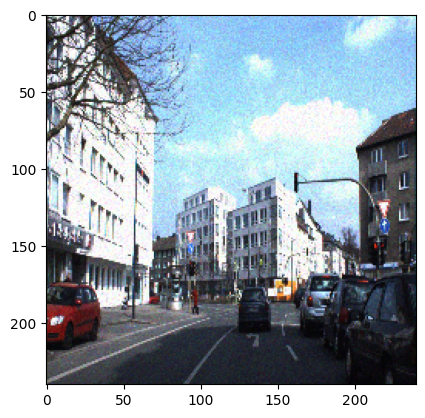

In [ ]:
plt.figure()
plt.imshow(output[p_c_filt][8,4].reshape((240, 240, 3)))

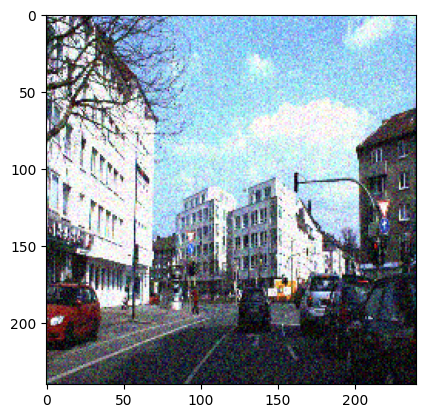

In [ ]:
plt.imshow(X_test[8, 8].reshape(240, 240, 3))

### Evaluation

In [ ]:
y_test = np.tile(y_test[:, None, :], (1, N_STEPS, 1))

In [ ]:
y_test.shape

In [ ]:
y_test

In [ ]:
with nengo_dl.Simulator(auto_net, minibatch_size=MINIBATCH_SIZE) as sim:
  sim.compile(optimizer = tf.optimizers.Adam(1e-5),
              loss = {p_c: tf.losses.mse,
                      p_c_filt: None}
             )
  print("Test error: ", sim.evaluate(X_test, {p_c: y_test}))

Build finished in 0:00:02                                                      
Optimization finished in 0:00:00                                               
Construction finished in 0:00:03                                               
/usr/local/lib/python3.10/dist-packages/nengo_dl/simulator.py:1892: UserWarning: Number of elements in input data (75) is not evenly divisible by Simulator.minibatch_size (32); input data will be truncated.
  warnings.warn(
2/2 [==============================] - 4s 284ms/step - loss: 1089.8281 - probe_loss: 1089.8281
Test error:  {'loss': 1089.828125, 'probe_loss': 1089.828125}
